In [1]:
import xarray as xr
import numpy as np
import scipy 
import matplotlib.pylab as plt
%matplotlib inline

## Read input SSH

In [2]:
ds = xr.open_dataset('/Users/eman/code_projects/data/scratch/NATL60_GULFSTREAM_degraded.nc')
# ds = ds.coarsen(lon=3,lat=3).mean()
ds

<xarray.Dataset>
Dimensions:   (time: 24, lat: 200, lon: 200)
Coordinates:
  * lon       (lon) float64 -64.97 -64.92 -64.87 -64.82 ... -55.12 -55.07 -55.02
  * lat       (lat) float64 33.03 33.08 33.13 33.18 ... 42.83 42.88 42.93 42.98
  * time      (time) datetime64[ns] 2012-10-01T00:30:00 ... 2012-10-01T23:30:00
Data variables:
    sossheig  (time, lat, lon) float32 ...
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

In [3]:
lon = ds.lon.values
lat = ds.lat.values
ssh = ds.sossheig[0].values


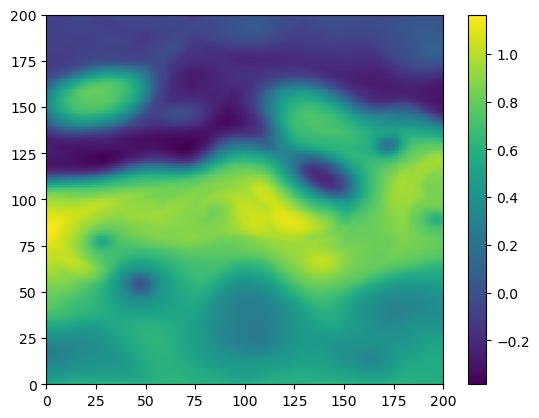

In [4]:
plt.figure()
plt.pcolormesh(ssh)
plt.colorbar()

## Forward elliptical equation: get PV from SSH on cartesian grid

$$ q = \frac{g}{f_0} \nabla^ 2 \eta - \frac{g f_0^2}{c_1^2} \eta $$

In [5]:
dx,dy = 4000, 4000 # meters
x = np.arange(0,dx*lon.size,dx)
y = np.arange(0,dy*lat.size,dy)

nx = lon.size
ny = lat.size


# Constants 
g = 9.91 # Gravity
f0 = 1e-5 # Coriolis frequency
c1 = 2.7 # First baroclinic phase speed

In [29]:
def _laplace(h):

        return (h[2:,1:-1]+h[:-2,1:-1]-2*h[1:-1,1:-1])/dy**2 + (h[1:-1,2:]+h[1:-1,:-2]-2*h[1:-1,1:-1])/dx**2

def ssh2pv(h, ssh_bv):
    
        q = np.zeros_like(h)
        
        q[1:-1,1:-1] = g/f0 * (_laplace(h) - (f0/c1)**2 * h[1:-1,1:-1])
        
        # Boundary condition
        q[0,:] = -g*f0/(c1**2) * ssh_bv[0,:]
        q[-1,:] = -g*f0/(c1**2) * ssh_bv[-1,:]
        q[:,0] = -g*f0/(c1**2) * ssh_bv[:,0]
        q[:,-1] = -g*f0/(c1**2) * ssh_bv[:,-1]
    
        return q



def compute_laplace_dst(nx, ny, dx, dy, dtype):
    """Discrete sine transform of the 2D centered discrete laplacian
    operator."""
    x, y = np.meshgrid(np.arange(1,nx-1, dtype=dtype),
                       np.arange(1,ny-1, dtype=dtype),
                       indexing='ij')
    return 2*(np.cos(np.pi/(nx-1)*x) - 1)/dx**2 + 2*(np.cos(np.pi/(ny-1)*y) - 1)/dy**2


## Inverse elliptical equation


This is bad:

$$
\begin{aligned}
\boldsymbol{\Delta}\mathbf{q} &=\mathbf{\psi} \\
\mathbf{q} &= \mathbf{f} 
\end{aligned}
$$

This is also bad:

$$
\begin{aligned}
\boldsymbol{\Delta}\mathbf{q} &=\mathbf{\psi} \\
\mathbf{q} &= \mathbf{0} 
\end{aligned}
$$

This is good:

$$
\begin{aligned}
\boldsymbol{\Delta}\mathbf{q} &=\mathbf{0} \\
\mathbf{q} &= \mathbf{f} 
\end{aligned}
$$

Technique de relevement.

**Sources**:
* [Blog Post](https://bthierry.pages.math.cnrs.fr/course-fem/lecture/boundary-conditions/dirichlet/)

In [32]:
norm = 'ortho'

dtype = 'float64' # 'float64'
ssh = ssh.astype(dtype)

# ssh boundary value
ssh_bv = np.copy(ssh)
ssh_bv[1:-1,1:-1] = 0

pv_ref = ssh2pv(ssh, ssh_bv)

# compute boundary contribution to PV
pv_bv = ssh2pv(ssh_bv, ssh_bv)

# # remove the boundary effect on PV
# pv_in = pv_ref[1:-1,1:-1] - pv_bv[1:-1,1:-1]

# remove the boundary effect on PV
pv_in = np.zeros_like(pv_ref)
pv_in = pv_ref[1:-1,1:-1] - pv_bv[1:-1,1:-1]

# Compute helmottz operator
laplace_dst = compute_laplace_dst(nx, ny, dx, dy, dtype)
helmoltz_dst = g/f0 * laplace_dst  - g*f0/c1**2

# Get pv from sine transform
pv_in_hat = scipy.fftpack.dst(scipy.fftpack.dst(pv_in,norm=norm, type=1).T, norm=norm, type=1).T

# Inverse sine tranfrom to get reconstructed ssh
ssh_rec = np.zeros_like(ssh)
ssh_rec[1:-1,1:-1] = scipy.fftpack.idst(
        scipy.fftpack.idst(pv_in_hat/helmoltz_dst, norm=norm, type=1).T,
    norm=norm, type=1).T

# # add the boundary value on SSH
# ssh_rec += ssh_bv
# add the boundary value on SSH
ssh_rec[0,:] = ssh_bv[0,:]
ssh_rec[-1,:] = ssh_bv[-1,:]
ssh_rec[:,0] = ssh_bv[:,0]
ssh_rec[:,-1] = ssh_bv[:,-1]


print(np.max(np.abs(ssh_rec - ssh)))

1.2090328738167955e-13


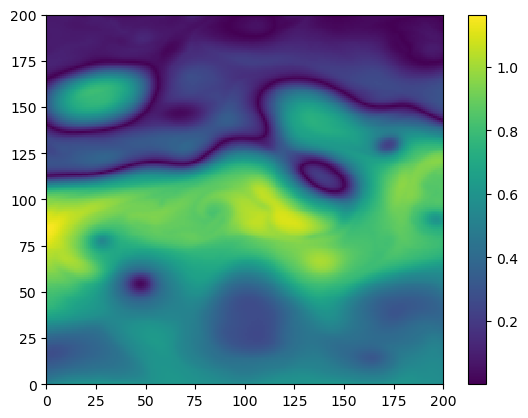

In [31]:
plt.figure()
plt.pcolormesh(np.abs(ssh-ssh_rec))
plt.colorbar()